In [10]:
# import tensorflow as tf
import pandas as pd
import sklearn
from datetime import datetime, timedelta

weather_df = pd.read_csv('weather_data.csv')
observations_df = pd.read_csv('observations.csv')

# convert datetime to same format as observations_df
weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime'], format='%Y%m%d%H')
weather_df['Date'] = weather_df['Datetime'].dt.date

# Use same format as weather_df
observations_df['Date'] = pd.to_datetime(observations_df[['year', 'month', 'day']])

# Group by id and Date to find all unique days per ID
day_indices = weather_df.groupby(['id', 'Date']).first().reset_index()

# remove windspeed and specific humidity columns
day_indices = day_indices.drop(columns=['Wind Speed', 'Specific Humidity'])

# make dict of observation ID with original date
observation_dates = {}
for _, row in observations_df.iterrows():
    observation_dates[row['id']] = row['Date']

# Calculate difference between observation date and weather date
def get_relative_day(row):
    obs_date = observation_dates.get(row['id'])
    this_date = pd.to_datetime(row['Date'])
    difference = (this_date - obs_date).days
    return difference

# Apply the function to get relative day
day_indices['RelativeDay'] = day_indices.apply(get_relative_day, axis=1)

# Add relative day to weather_df
day_map = day_indices.set_index(['id', 'Date'])['RelativeDay']
weather_df['RelativeDay'] = weather_df.set_index(['id', 'Date']).index.map(day_map)

# Variables to calculate aggregations for
weather_vars = ['Temperature', 'Humidity','Dew/Frost Point', 
                'Wet Bulb Temperature', 'Precipitation', 'Soil Temperature']

# Time windows to aggregate over (days before and after the observation day)
time_windows = {
    'day_of': (0, 0),
    'day_before_after': (-1, 1),
    'three_days': (-3, 3),
    'one_week': (-7, 7),
    'two_weeks': (-14, 14)
}

# Function to calculate aggregates given ID and time window
def calculate_aggregates(weather_subset, var_name, window_name, start_day, end_day):
    # Filter data for given time window
    window_data = weather_subset[(weather_subset['RelativeDay'] >= start_day) & (weather_subset['RelativeDay'] <= end_day)]
    
    # Calculate aggregate and return as a series
    result = pd.Series({
        f"{var_name}_{window_name}_mean": window_data[var_name].mean(),
        f"{var_name}_{window_name}_min": window_data[var_name].min(),
        f"{var_name}_{window_name}_max": window_data[var_name].max(),
        f"{var_name}_{window_name}_median": window_data[var_name].median()
    })
    
    return result

# Create empty DataFrame to store results
all_features = []
result_rows = []

# For each observation row, calculate all aggregate weather data
for id_val in observations_df['id'].unique():
    id_weather = weather_df[weather_df['id'] == id_val]
        
    # Dictionary to store aggregated values for this ID
    id_features = {'id': id_val}
    
    # Iterate over all weather data variables
    for var in weather_vars:
        # iterate over all items in time_windows
        for window_name, (start_day, end_day) in time_windows.items():
            aggs = calculate_aggregates(id_weather, var, window_name, start_day, end_day)
            id_features.update(aggs)
            
            # Add feature names to our list (only once)
            if id_val == observations_df['id'].unique()[0]:
                all_features.extend(aggs.index.tolist())
    
    result_rows.append(id_features)

# Create DataFrame from results
aggregated_features = pd.DataFrame(result_rows)

# Merge with the original observations dataframe
observations_df = observations_df.merge(aggregated_features, on='id', how='left')

# Create list of feature names
weather_feature_names = all_features

print(f"Created {len(weather_feature_names)}  features")



# Add day of year as a feature to observations_df
observations_df['day_of_year'] = observations_df.apply(
    lambda row: datetime(row['year'], row['month'], row['day']).timetuple().tm_yday, 
    axis=1
)

# Drop rows with NaN values
observations_df = observations_df.dropna()

# Display the updated DataFrame
observations_df.head()
# Save the updated DataFrame to a new CSV file
observations_df.to_csv('observations_with_weather_features.csv', index=False)


Created 120  features


Epoch 1/50
7/7 [==============================] - 1s 41ms/step - loss: 8.4469 - accuracy: 0.4216 - val_loss: 5.1262 - val_accuracy: 0.5000
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 4.9956 - accuracy: 0.4657 - val_loss: 2.2003 - val_accuracy: 0.5000
Epoch 3/50
7/7 [==============================] - 0s 7ms/step - loss: 3.8934 - accuracy: 0.4608 - val_loss: 2.3222 - val_accuracy: 0.5000
Epoch 4/50
7/7 [==============================] - 0s 7ms/step - loss: 3.0831 - accuracy: 0.5294 - val_loss: 1.3446 - val_accuracy: 0.5577
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 2.5176 - accuracy: 0.5392 - val_loss: 1.2946 - val_accuracy: 0.5192
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 2.2763 - accuracy: 0.5049 - val_loss: 1.3217 - val_accuracy: 0.6154
Epoch 7/50
7/7 [==============================] - 0s 11ms/step - loss: 2.0334 - accuracy: 0.5000 - val_loss: 1.0562 - val_accuracy: 0.5577
Epoch 8/50
7/7 [==============

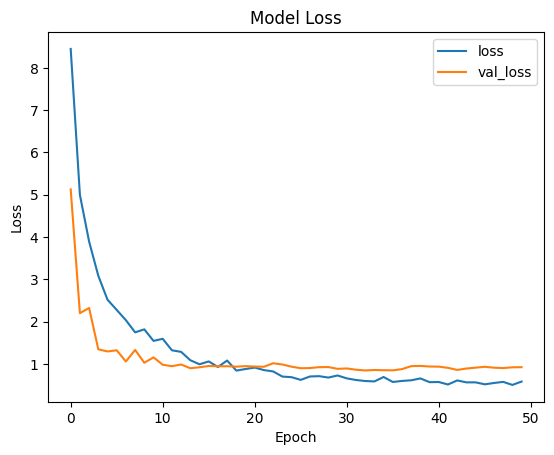

3/3 [==============================] - 0s 2ms/step


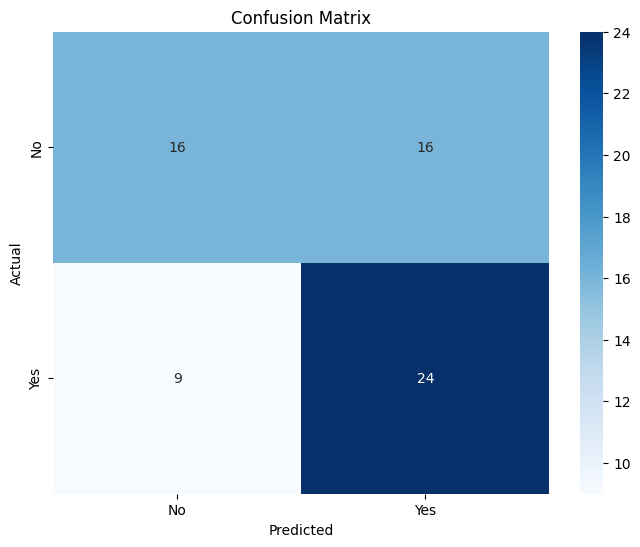

              precision    recall  f1-score   support

          No       0.64      0.50      0.56        32
         Yes       0.60      0.73      0.66        33

    accuracy                           0.62        65
   macro avg       0.62      0.61      0.61        65
weighted avg       0.62      0.62      0.61        65



In [23]:
from sklearn.model_selection import train_test_split

import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random


# set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# Define the features and target variable
features = weather_feature_names + ['day_of_year']
target = 'PowderyMildew'

X = observations_df[features]
y = observations_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(features),)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation ='sigmoid')  # Output layer
])
# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
# Plot training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Save the model
model.save('powdery_mildew_model.h5')
# Load the model
loaded_model = tf.keras.models.load_model('powdery_mildew_model.h5')
# Make predictions
predictions = loaded_model.predict(X_test)
# Display predictions
predictions_df = pd.DataFrame({'Predicted': predictions.flatten(), 'Actual': y_test})
predictions_df.head()

# test and output confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
# Convert predictions to binary classification
threshold = 0.5
y_pred_binary = (predictions.flatten() > threshold).astype(int)
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Print classification report
print(classification_report(y_test, y_pred_binary, target_names=['No', 'Yes']))
